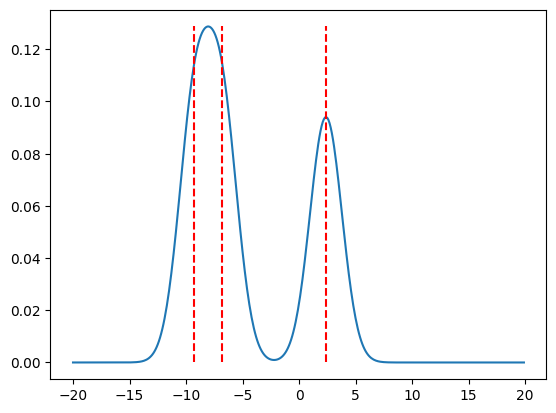

In [5]:

from src_bis.gmm import GMM 
import torch 

gmm = GMM(d=1)

from matplotlib import pyplot as plt
x = torch.arange(-20,20,0.1)
y = gmm.prob(x[:,None,None])
plt.plot(x,y )
plt.vlines(gmm.means, ymin = 0, ymax = y.max(), colors = "r", ls = "--")

Generating noise
[[[2. 0.]
  [0. 2.]]

 [[2. 0.]
  [0. 2.]]]


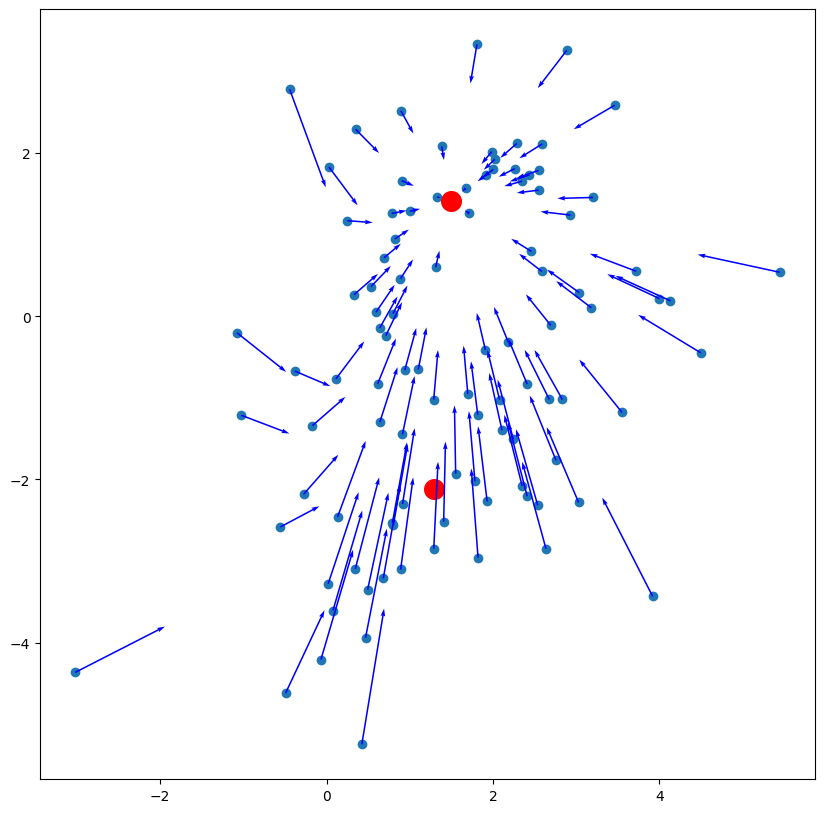

In [80]:
from src_bis.gmm import IGMM 


B= 100
vgmm = IGMM(d = 2, scale = 2, n_components = 2, s = 10)
vgmm.means  = vi.vgmm.means
samples = vgmm.sample(100)
plt.figure(figsize=(10,10))
# plt.ylim((-15,15))
# plt.xlim((-15,15))
plt.scatter(samples[:,0],samples[:,1])

plt.scatter(vgmm.means[:,0],vgmm.means[:,1], s = 200, color = "r")
grad = vgmm.gradient_log_density(samples)
s =5
print(vgmm.covariances)
plt.quiver(samples[:, 0], samples[:, 1], grad[:, 0]*s, grad[:, 1]*s, 
           angles="xy", scale_units="xy", scale=10, color="blue", alpha=1, width=0.002)


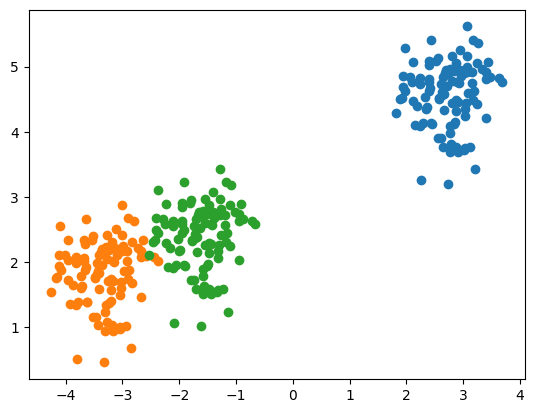

In [88]:

# samples = vgmm.gaussians.sample((1000,))
samples = vgmm.sample_from_each_gaussian(B = 100) # N, B, D
n = vgmm.n_components
for i in range(n):
    plt.scatter(samples[i,:,0], samples[i,:,1])

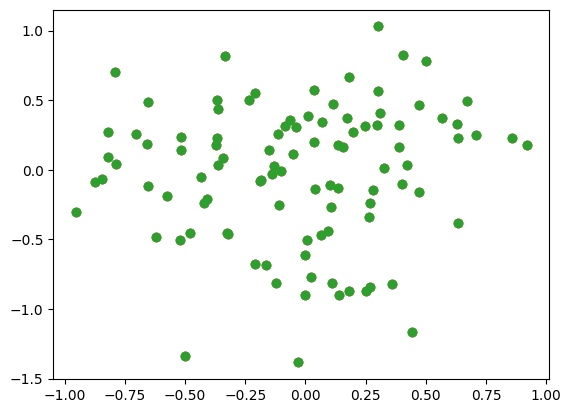

In [89]:

centered = (samples - vgmm.means[:,None])
for i in range(n):
    plt.scatter(centered[i,:,0], centered[i,:,1])


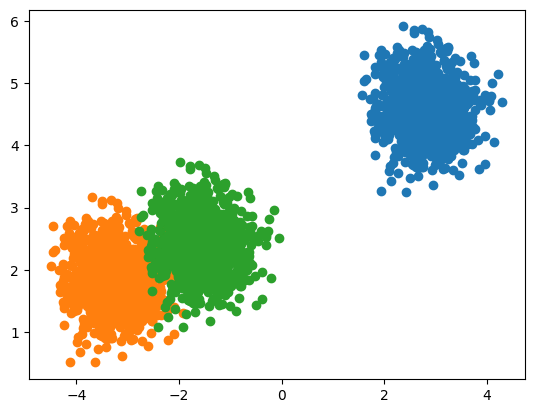

In [100]:
from einops import rearrange

B= 1000
samples = vgmm.sample_from_each_gaussian(B = B)
samples_flat = rearrange(samples, "n b d -> (n b) d")
for i in range(vgmm.n_components):
    plt.scatter(samples_flat[i*B:(i+1)*B,0], samples_flat[i*B:(i+1)*B,1])

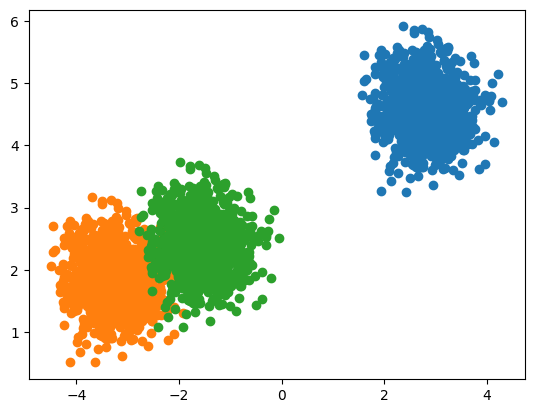

In [101]:
samples_rerearrange = rearrange(samples_flat, "(n b) d -> n b d", b = B)
for i in range(vgmm.n_components):
    plt.scatter(samples_rerearrange[i,:,0], samples_rerearrange[i,:,1])

In [112]:
target = GMM(d = 2, mode = "iso", scale = 0.1, n_components = 3, s = 10)


In [46]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import numpy.linalg as LA 
from src_bis.gmm import GMM



class LogReg:
    def __init__(self, dataset=None, n_samples=100, d=2, Z = 100, meanShift = 1):
        
        self.scaler = StandardScaler()
        self.Z = Z
        self.fixed_theta = None
        self.meanShift = meanShift

        if dataset is None:
            self.d = d
            self.n_samples = n_samples
            self.generate_data(n_samples, d )
        else:
            self.load_data(dataset)


    def generate_data(self, n_samples, d):

        mean = np.random.rand(d,)
        mean /= LA.norm(mean)
        self.mean0 = mean*self.meanShift/2
        self.mean1 = -mean*self.meanShift/2
        self.cov = GMM.generate_random_covs( n = 1, d = d, mode = "full", scale=np.sqrt(d))[0]

        X0 = np.random.multivariate_normal(self.mean0, self.cov, int(n_samples/2))
        X1 = np.random.multivariate_normal(self.mean1, self.cov, int(n_samples/2))
        X = np.concatenate((X0,X1))
        X = self.scaler.fit_transform(X)

        y0 = np.zeros((int(n_samples/2),1))
        y1 = np.ones((int(n_samples/2),1))
        y = np.concatenate((y0,y1))

        data = list(zip(y, X))
        np.random.shuffle(data)
        self.y, self.X = zip(*data)
        self.y = np.array(self.y)[:,0]
        self.X = np.array(self.X)
       

    def load_data(self, dataset):
        X, y = dataset
        self.X = self.scaler.fit_transform(X)
        self.y = y.reshape(-1, 1)
        self.n_samples, self.d = X.shape
        
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def unormalized_logpdf(self, theta):
        logits = np.dot(self.X, theta)
        return  np.sum(self.y * logits - np.log(1 + np.exp(logits))) 
    
    def unormalized_pdf(self, theta):
        return np.exp(self.log_prob(theta))
    
    def prob(self, X):
        X_scaled = self.scaler.transform(X)
        logits = np.dot(X_scaled, self.theta) 
        return self.sigmoid(logits)
    
    def log_prob(self, X):
        probs = self.prob(X)
        return np.log(probs)


    def grad_log_density(self, theta):  ### theta can be sample so of shape B, d
        return ((self.y - self.sigmoid(np.dot(theta, self.X.T)))[...,None] * self.X).sum(axis = 1) # shape B, d

    def gradient(self, theta):
        return np.sum(self.X * (self.y - self.sigmoid(np.dot(self.X, theta))))
    

    def compute_KL(self, vgmm, B = 1000):
        samples = vgmm.sample(B)
        GM_entropy  = vgmm.negative_entropy(B)

        return GM_entropy - self.unormalized_logpdf(samples).mean()

  0%|          | 46/20000 [00:00<01:27, 228.48it/s]

KL  3.1965514592967694


  5%|▌         | 1065/20000 [00:03<00:56, 334.86it/s]

KL  0.170976518087226


 10%|█         | 2035/20000 [00:06<00:52, 339.31it/s]

KL  0.04993976176604989


 15%|█▌        | 3064/20000 [00:09<00:48, 347.81it/s]

KL  0.034185324149281014


 20%|██        | 4041/20000 [00:12<00:47, 338.46it/s]

KL  0.03104864689550788


 25%|██▌       | 5061/20000 [00:15<00:47, 316.09it/s]

KL  0.02991844309406243


 30%|███       | 6047/20000 [00:18<00:40, 346.77it/s]

KL  0.028929501624673396


 35%|███▌      | 7050/20000 [00:21<00:36, 355.15it/s]

KL  0.027466908124559063


 40%|████      | 8066/20000 [00:24<00:33, 353.17it/s]

KL  0.02548554772453698


 45%|████▌     | 9067/20000 [00:27<00:30, 353.62it/s]

KL  0.023019876587577762


 50%|█████     | 10063/20000 [00:30<00:30, 323.59it/s]

KL  0.020288026276841856


 55%|█████▌    | 11060/20000 [00:32<00:25, 349.88it/s]

KL  0.017980448662643565


 60%|██████    | 12062/20000 [00:35<00:23, 341.91it/s]

KL  0.015440282108447946


 65%|██████▌   | 13055/20000 [00:38<00:21, 330.05it/s]

KL  0.01390048997139747


 70%|███████   | 14055/20000 [00:41<00:16, 350.10it/s]

KL  0.01299512035919088


 75%|███████▌  | 15049/20000 [00:44<00:14, 346.53it/s]

KL  0.012552176487855988


 80%|████████  | 16037/20000 [00:47<00:11, 349.52it/s]

KL  0.012461875664612286


 85%|████████▌ | 17034/20000 [00:50<00:08, 345.02it/s]

KL  0.012470779548605763


 90%|█████████ | 18058/20000 [00:53<00:05, 331.93it/s]

KL  0.012599296602718088


 95%|█████████▌| 19070/20000 [00:56<00:02, 341.24it/s]

KL  0.012564990461336845


100%|██████████| 20000/20000 [00:59<00:00, 336.53it/s]


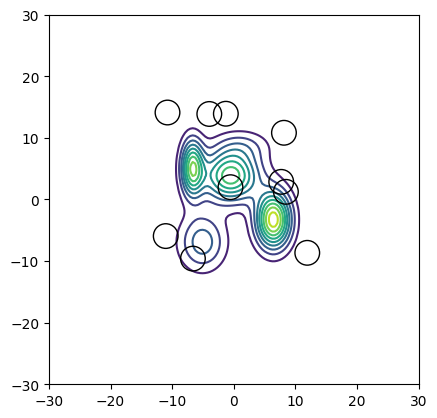

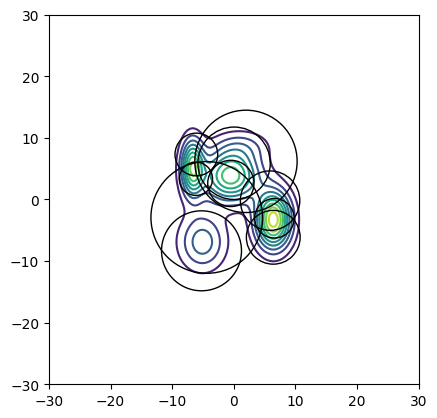

In [70]:

from src_bis.optim import VI_IGMM
from matplotlib import pyplot as plt 
from src_bis.target import Target
from src_bis.gmm import IGMM

# target = Target("gmm", n_components=5, s = 10, scale = 10,  d = 2)
# v = IGMM( n_components=30, s = 20, scale = 2,  d = 2)

vi = VI_IGMM(target, learning_rate=0.1, n_iterations=20000, n_components = 10, scale = 2, BG = 10, s = 15)
vi.optimize(ibw = True, md  = False, means_only=False, plot_iter=1000, gen_noise=True)


ax = target.plot()
vi.vgmm.plot_circle(0, ax,bound = 30)

ax = target.plot()
vi.vgmm.plot_circle(-1, ax,bound = 30)
# v.plot_circle(0, ax, bound=30)


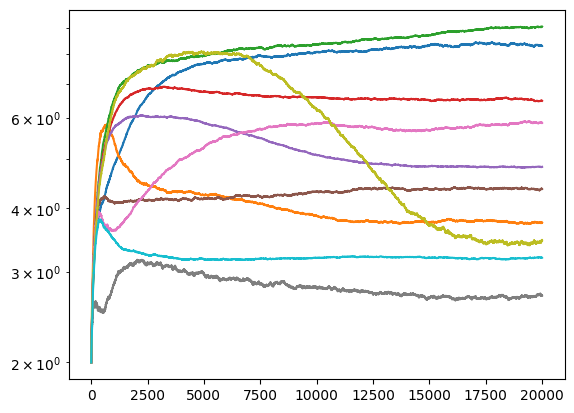

In [71]:
plt.semilogy(vi.vgmm.optimized_epsilons)

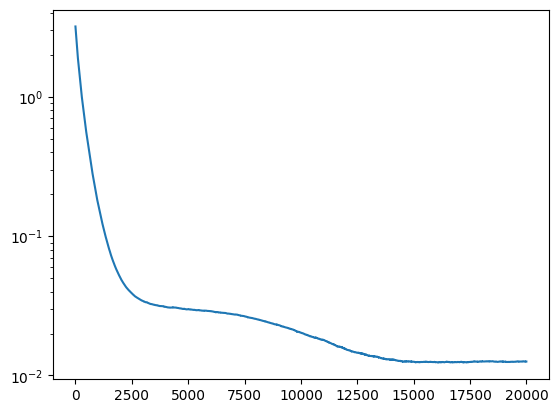

In [72]:
plt.semilogy(vi.kls)

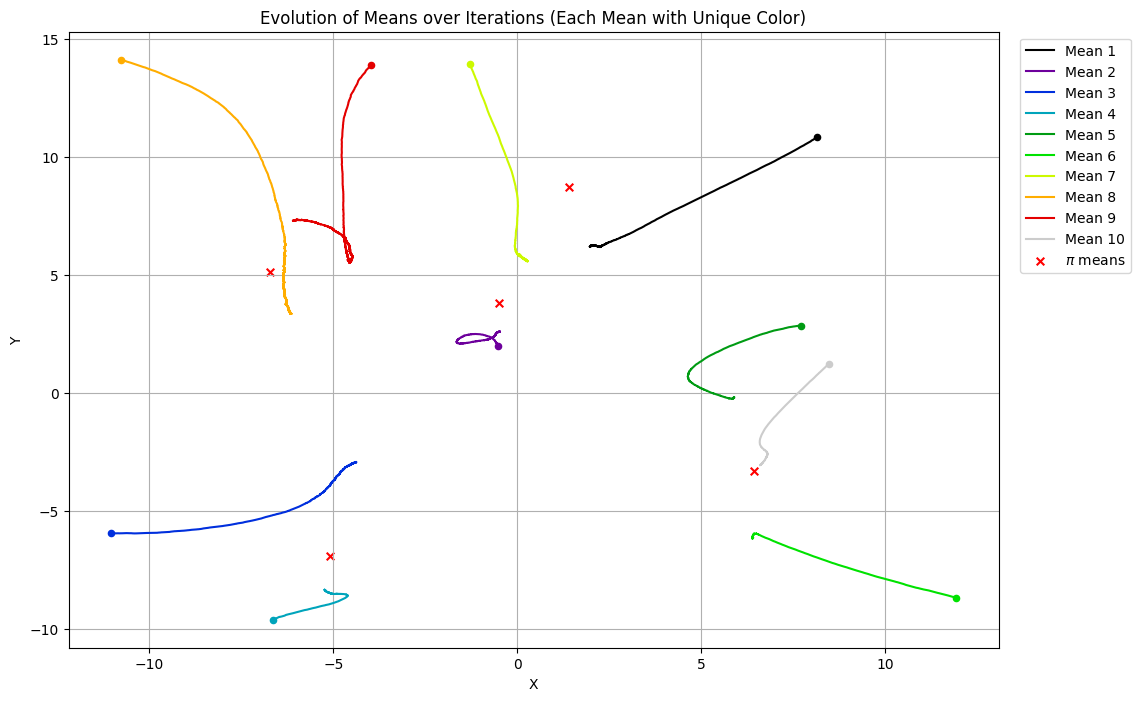

In [73]:
import numpy as np 
means =  np.array(vi.vgmm.optimized_means)
N_mixture =  means.shape[1]

pi_mean =  vi.target.model.means
colors = plt.cm.nipy_spectral(np.linspace(0, 1, N_mixture))

plt.figure(figsize=(12, 8))

stop =  -2

for i in range(N_mixture):
    x_values = means[:, i, 0]
    y_values = means[:, i, 1]

    plt.plot(x_values, y_values, color=colors[i], label=f'Mean {i+1}')
    plt.scatter(x_values[0], y_values[0], color=colors[i], s=20, marker='o')

plt.scatter(pi_mean[:,0], pi_mean[:,1], color = "red", alpha = 1, marker = "x", s = 30, label = "$\pi$ means")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Evolution of Means over Iterations (Each Mean with Unique Color)")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.show()

In [79]:

from src_bis.optim import VI_IGMM
from matplotlib import pyplot as plt 
from src_bis.target import Target
from src_bis.gmm import IGMM

# target = Target("gmm", n_components=5, s = 10, scale = 10,  d = 2)
# v = IGMM( n_components=30, s = 20, scale = 2,  d = 2)

vis = [VI_IGMM(target, learning_rate=1, n_iterations=10000, n_components = n, scale = 2, BG = 100, s = 15) for n in [1, 10, 30]]
[vi.optimize(ibw = True, md  = False, means_only=False, plot_iter=10000, gen_noise=True) for vi in vis]

# ax = target.plot()
# vi.vgmm.plot_circle(0, ax,bound = 30)

# ax = target.plot()
# vi.vgmm.plot_circle(-1, ax,bound = 30)
# v.plot_circle(0, ax, bound=30)


  1%|          | 62/10000 [00:00<00:31, 315.67it/s]

KL  2.0030316235856955


  0%|          | 42/10000 [00:00<00:48, 204.87it/s]

KL  3.222845189372402


  0%|          | 12/10000 [00:00<03:02, 54.67it/s]

KL  2.7640622561821493


100%|██████████| 10000/10000 [03:12<00:00, 51.98it/s]


[None, None, None]

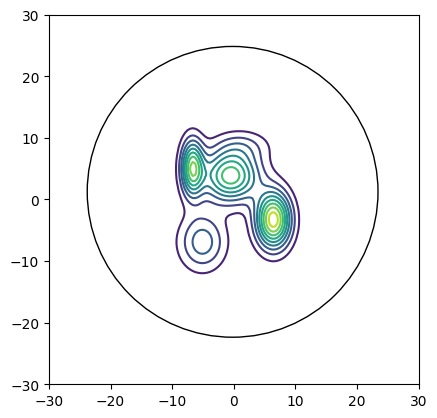

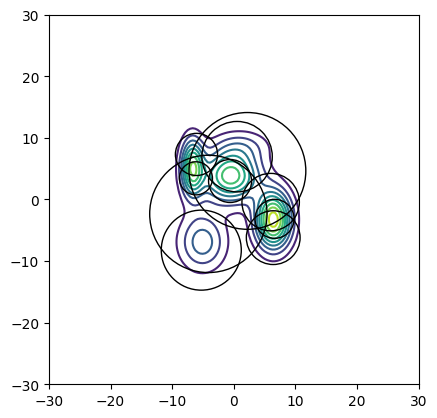

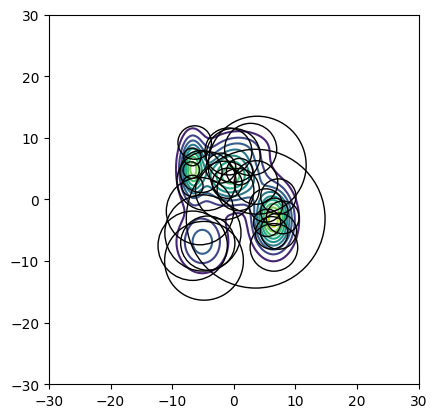

In [80]:
n = [1, 10, 30]
for i,vi in enumerate(vis):
    ax = target.plot()
    vi.vgmm.plot_circle(-1, ax,bound = 30)
    plt.show()
    


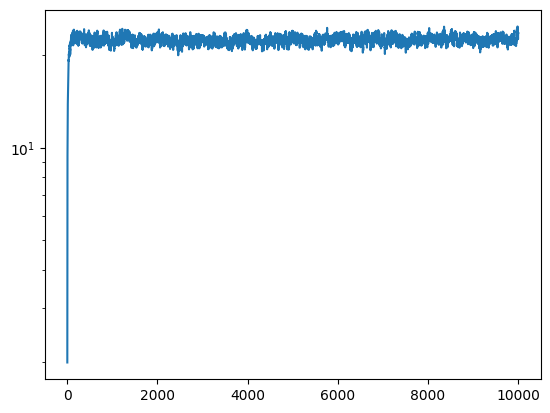

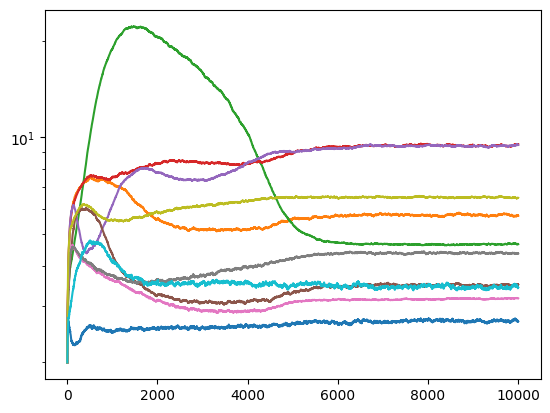

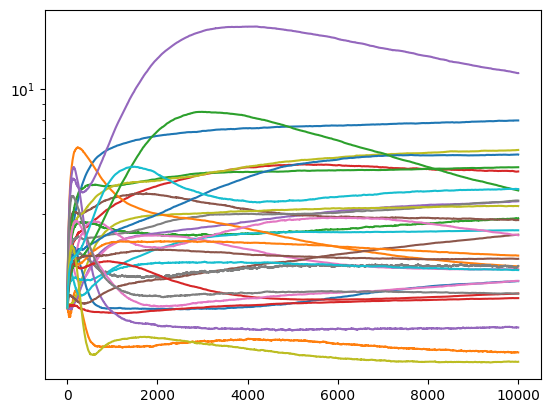

In [81]:
n = [1, 10, 30]
for i,vi in enumerate(vis):
    plt.semilogy(vi.vgmm.optimized_epsilons)
    plt.show()
    


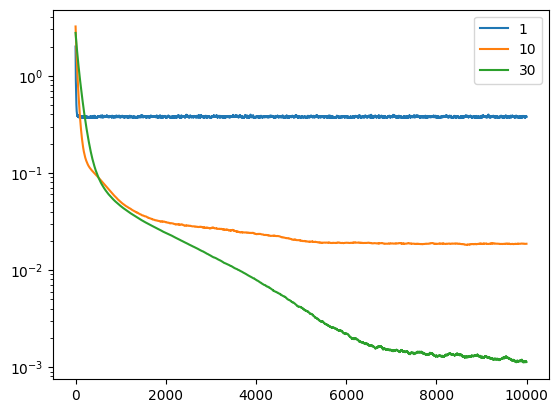

In [82]:
n = [1, 10, 30]
for i,vi in enumerate(vis):
    plt.semilogy(vi.kls, label = str(n[i]))
    
plt.legend()

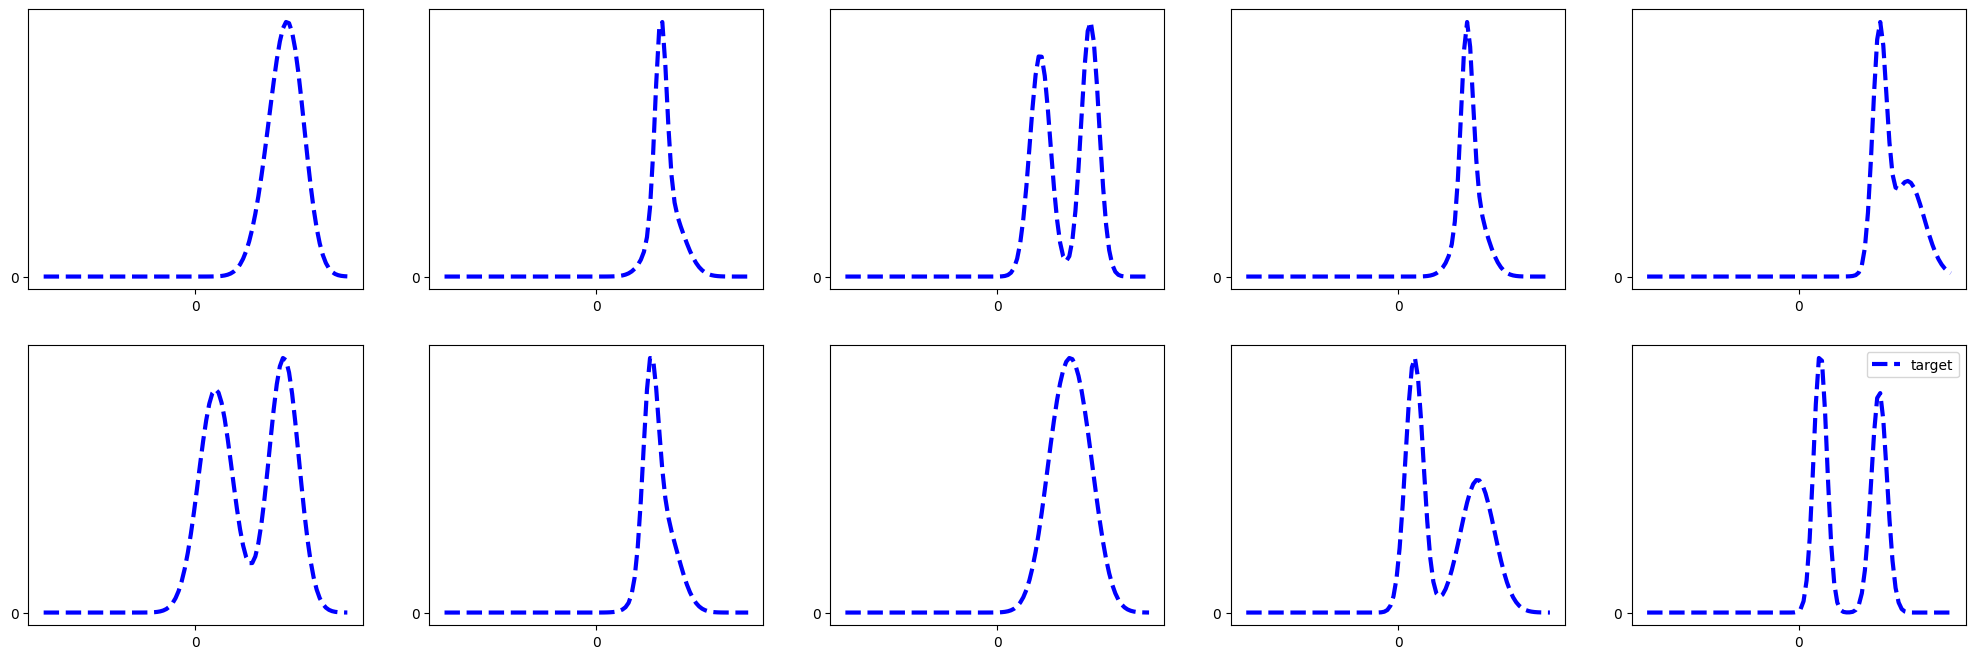

In [195]:
from scipy.stats import norm  # 1D normal for marginal
import numpy as np 

d = 10
target = Target("gmm",mode = "diag", n_components=2, s = np.sqrt(d) * 5, scale = np.sqrt(d)*10,  d = d)
target.model.means  = target.model.means + 20 
bound = 50
grid_size = 100
x_grid = np.linspace(-bound, bound, grid_size)

grid_rows = 2
grid_cols = 5

fig, axes = plt.subplots(d//5, 5, figsize=(5 * grid_cols, 4 * grid_rows))
axes = axes.flatten()  # Flatten for easy indexing

pi_mean = target.model.means
pi_cov = target.model.covariances

for j in range(d):
    # Marginal for dimension j: Estimated distribution
   
    # Marginal for dimension j: Target distribution
    target_marginals = [
        norm.pdf(x_grid, loc=pim[j], scale=np.sqrt(pic[j, j]))
        for pim, pic in zip(pi_mean, pi_cov)
    ]
    Z_target = np.sum(target_marginals, axis=0) / len(target_marginals)

    axes[j].plot(x_grid, Z_target, label="target", color="blue", linestyle="--", linewidth=3)
    # axes[j].set_title(f"dim {j}", fontweight='bold')
    axes[j].set_xticks([0])
    axes[j].set_yticks([0])

    
plt.legend()


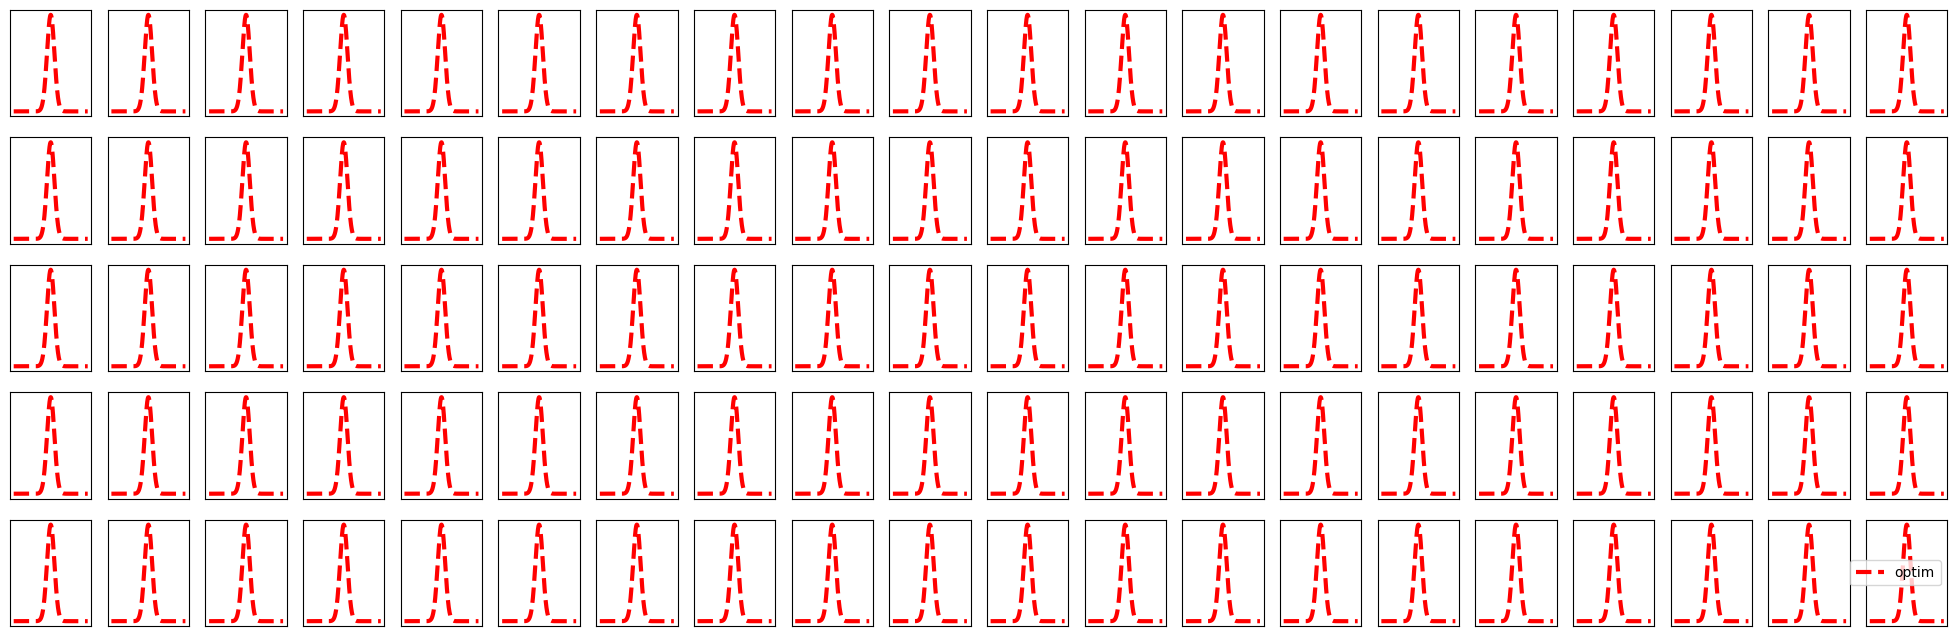

In [123]:

fig, axes = plt.subplots(5, 20, figsize=(5 * grid_cols, 4 * grid_rows))
axes = axes.flatten()  # Flatten for easy indexing

pi_mean = vi.vgmm.optimized_means[0]
pi_cov = vi.vgmm.optimized_covs[0]

bound = 10000
grid_size = 10000
x_grid = np.linspace(-bound, bound, grid_size)

for j in range(d):
    # Marginal for dimension j: Estimated distribution
   
    # Marginal for dimension j: Target distribution
    target_marginals = [
        norm.pdf(x_grid, loc=pim[j], scale=1000)
        for pim, pic in zip(pi_mean, pi_cov)
    ]
    Z_target = np.sum(target_marginals, axis=0) / len(target_marginals)

    axes[j].plot(x_grid, Z_target, label="optim", color="red", linestyle="--", linewidth=3)
    # axes[j].set_title(f"dim {j}", fontweight='bold')
    axes[j].set_xticks([])
    axes[j].set_yticks([])

    
plt.legend()

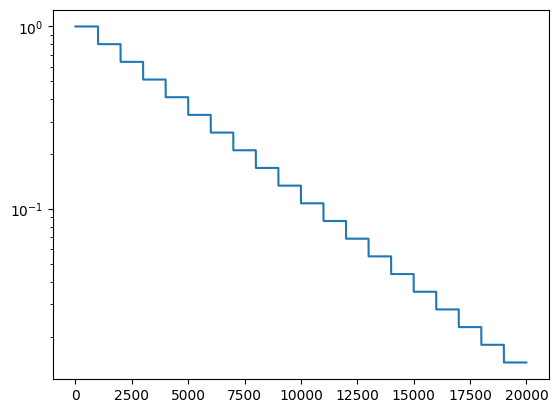

In [4]:
import math 
from matplotlib import pyplot as plt 

initial_learning_rate = 1 
def lr_step_based_decay(epoch):
    drop_rate = 0.8
    epochs_drop = 1000.0  

    decay_factor = math.pow(drop_rate, math.floor(epoch / epochs_drop))
    new_learning_rate = initial_learning_rate * decay_factor

    return new_learning_rate
lrs = []
for  i in  range(20000):
    lrs.append(lr_step_based_decay(i))

plt.semilogy(lrs)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 3/10000 [00:00<07:17, 22.85it/s]

LR 1.0
KL  301.65723554172587


 10%|█         | 1007/10000 [00:32<04:22, 34.24it/s]

LR 0.9
KL  9.062381608554238


 20%|██        | 2004/10000 [01:09<05:21, 24.84it/s]

LR 0.81
KL  2.1751097695561916


 30%|███       | 3004/10000 [01:46<03:43, 31.25it/s]

LR 0.7290000000000001
KL  1.853282222262339


 40%|████      | 4005/10000 [02:22<03:26, 28.99it/s]

LR 0.6561
KL  1.817027827549187


 50%|█████     | 5005/10000 [02:56<03:20, 24.91it/s]

LR 0.5904900000000001
KL  1.8084499866687898


 60%|██████    | 6006/10000 [03:31<02:18, 28.76it/s]

LR 0.531441
KL  1.8055906731133329


 70%|███████   | 7005/10000 [04:10<01:38, 30.37it/s]

LR 0.4782969000000001
KL  1.8034533957903058


 80%|████████  | 8004/10000 [04:44<00:59, 33.36it/s]

LR 0.4304672100000001
KL  1.8022366464224366


 90%|█████████ | 9005/10000 [05:15<00:32, 30.84it/s]

LR 0.3874204890000001
KL  1.8007401325757018


100%|██████████| 10000/10000 [05:51<00:00, 28.49it/s]


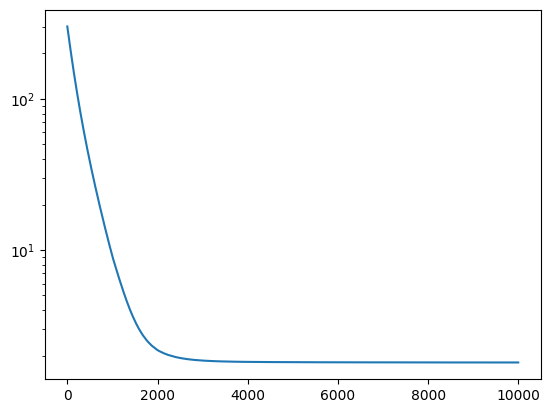

In [18]:

from src_bis.optim import VI_IGMM
from matplotlib import pyplot as plt 
from src_bis.target import Target
from src_bis.gmm import IGMM
import numpy as np 

d = 20
# target = Target("gmm",mode = "diag", n_components=5, s = np.sqrt(d) * 5, scale = np.sqrt(d)*10,  d = d)
target = Target("gmm",mode = "diag", n_components=5, s = np.sqrt(d) * 5, scale = np.sqrt(d)*10,  d = d)

vi = VI_IGMM(target, learning_rate = 1, n_iterations=10000, n_components = 20, scale = np.sqrt(d)*10 , BG = 100, s = np.sqrt(d) * 10, d = d)
vi.epochs_drop = 1000
vi.drop_rate = 0.9
vi.optimize(ibw = True, md  = False, means_only=False, plot_iter=1000, gen_noise=True,  scheduler=True, save_grads=False)


plt.semilogy(vi.kls)
# v.plot_circle(0, ax, bound=30)


In [19]:
vi2 = VI_IGMM(target, learning_rate = 1, n_iterations=10000, n_components = 20, scale = np.sqrt(d)*10 , BG = 100, s = np.sqrt(d) * 10, d = d)

vi2.optimize(ibw = True, md  = False, means_only=False, plot_iter=1000, gen_noise=True, save_grads=False)



  0%|          | 3/10000 [00:00<07:28, 22.27it/s]

LR 1
KL  272.5481349812999


 10%|█         | 1005/10000 [00:36<06:07, 24.46it/s]

LR 1
KL  7.917217894561492


 20%|██        | 2006/10000 [01:11<04:31, 29.48it/s]

LR 1
KL  2.0431910547051166


 30%|███       | 3005/10000 [01:47<04:25, 26.35it/s]

LR 1
KL  1.8353766788208394


 40%|████      | 4004/10000 [02:25<04:10, 23.94it/s]

LR 1
KL  1.8174561193143177


 50%|█████     | 5004/10000 [02:57<02:33, 32.62it/s]

LR 1
KL  1.8127316557005535


 60%|██████    | 6006/10000 [03:29<02:15, 29.56it/s]

LR 1
KL  1.8109364597100244


 70%|███████   | 7006/10000 [04:01<01:33, 31.97it/s]

LR 1
KL  1.8082533817994142


 80%|████████  | 8006/10000 [04:32<01:02, 31.95it/s]

LR 1
KL  1.8065270462968037


 90%|█████████ | 9005/10000 [05:04<00:30, 32.33it/s]

LR 1
KL  1.804520946851246


100%|██████████| 10000/10000 [05:35<00:00, 29.81it/s]


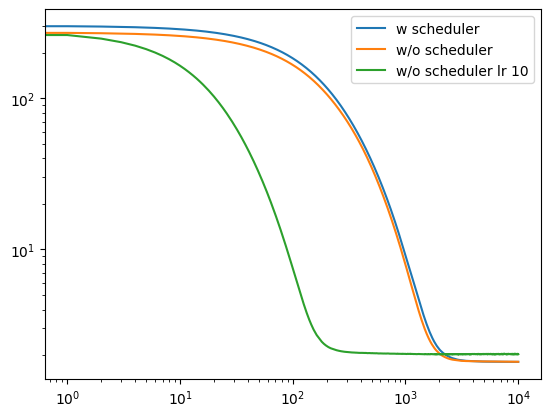

In [94]:
plt.loglog(vi.kls, label= "w scheduler")
plt.loglog(vi2.kls, label = "w/o scheduler")
plt.loglog(vi3.kls, label = "w/o scheduler lr 10")
plt.legend()

In [20]:
vi3 = VI_IGMM(target, learning_rate = 10, n_iterations=10000, n_components = 20, scale = np.sqrt(d)*10 , BG = 100, s = np.sqrt(d) * 10, d = d)

vi3.optimize(ibw = True, md  = False, means_only=False, plot_iter=1000, gen_noise=True, save_grads=False, scheduler = False)



  0%|          | 5/10000 [00:00<06:50, 24.37it/s]

LR 10
KL  277.153282401998


 10%|█         | 1006/10000 [00:35<05:54, 25.38it/s]

LR 10
KL  2.033539205858278


 20%|██        | 2005/10000 [01:12<05:36, 23.73it/s]

LR 10
KL  2.018835424128934


 30%|███       | 3004/10000 [01:54<04:32, 25.64it/s]

LR 10
KL  2.02261379040164


 40%|████      | 4006/10000 [02:30<03:14, 30.81it/s]

LR 10
KL  2.028401621462362


 50%|█████     | 5007/10000 [03:03<02:43, 30.50it/s]

LR 10
KL  2.0301858165498


 60%|██████    | 6002/10000 [03:37<07:33,  8.81it/s]

LR 10
KL  2.0309585454352375


 70%|███████   | 7006/10000 [04:21<01:53, 26.27it/s]

LR 10
KL  2.0277943825590174


 80%|████████  | 8006/10000 [04:57<01:03, 31.44it/s]

LR 10
KL  2.0297151018225486


 90%|█████████ | 9004/10000 [05:35<00:31, 31.49it/s]

LR 10
KL  2.027808131833532


100%|██████████| 10000/10000 [06:17<00:00, 26.51it/s]


In [240]:
vi4 = VI_IGMM(target, learning_rate = 10, n_iterations=10000, n_components = 20, scale = np.sqrt(d)*10 , BG = 100, s = np.sqrt(d) * 10, d = d )
vi4.epochs_drop = 1000
vi4.drop_rate = 0.9
vi4.optimize(ibw = True, md  = False, means_only=False, plot_iter=1000, gen_noise=True, save_grads=False, scheduler = True)


  0%|          | 5/10000 [00:00<06:36, 25.20it/s]

LR 10.0
KL  287.0098069075165


 10%|█         | 1006/10000 [00:32<04:32, 33.05it/s]

LR 9.0
KL  2.008466449537916


 20%|██        | 2004/10000 [01:09<06:15, 21.32it/s]

LR 8.100000000000001
KL  2.004798739177159


 30%|███       | 3006/10000 [01:45<05:02, 23.16it/s]

LR 7.290000000000001
KL  2.003493368955769


 40%|████      | 4004/10000 [02:23<03:27, 28.83it/s]

LR 6.561
KL  2.00346249559377


 50%|█████     | 5004/10000 [03:00<03:04, 27.11it/s]

LR 5.9049000000000005
KL  2.001553946286891


 60%|██████    | 6005/10000 [03:37<02:14, 29.78it/s]

LR 5.3144100000000005
KL  2.000454518627417


 70%|███████   | 7005/10000 [04:10<01:33, 31.98it/s]

LR 4.7829690000000005
KL  2.001714447921466


 80%|████████  | 8004/10000 [04:42<01:01, 32.72it/s]

LR 4.304672100000001
KL  2.0002971374024825


 90%|█████████ | 9007/10000 [05:14<00:30, 32.62it/s]

LR 3.874204890000001
KL  2.000719903016086


100%|██████████| 10000/10000 [05:45<00:00, 28.92it/s]


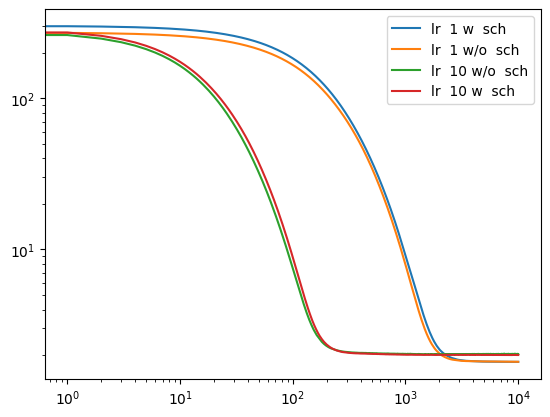

In [248]:
plt.loglog(vi.kls, label = "lr  1 w  sch")
plt.loglog(vi2.kls,  label = "lr  1 w/o  sch")
plt.loglog(vi3.kls,  label = "lr  10 w/o  sch")
plt.loglog(vi4.kls, label = "lr  10 w  sch")
plt.legend()

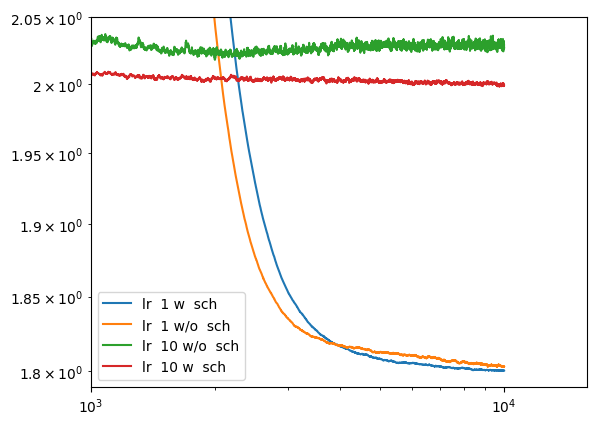

In [258]:
plt.loglog(vi.kls, label = "lr  1 w  sch")
plt.loglog(vi2.kls,  label = "lr  1 w/o  sch")
plt.loglog(vi3.kls,  label = "lr  10 w/o  sch")
plt.loglog(vi4.kls, label = "lr  10 w  sch")
plt.xlim(1000)
plt.ylim(1.79,  2.05)
plt.legend()

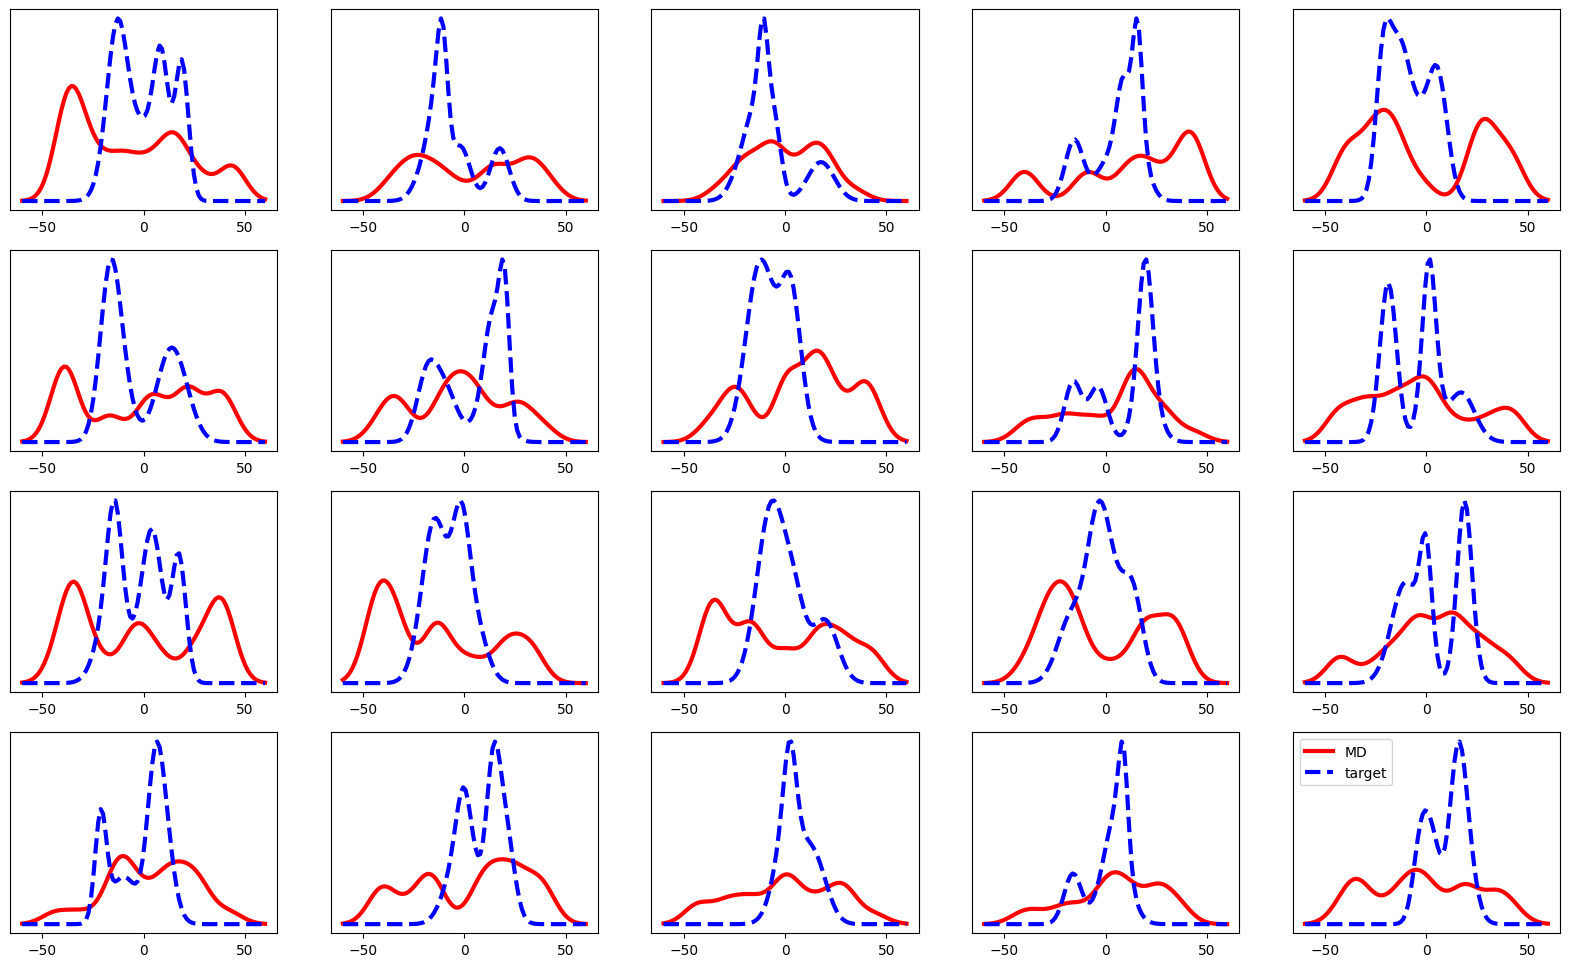

In [92]:
from scipy.stats import norm  # 1D normal for marginal
import numpy as np 
bound = 60
grid_size = 100
x_grid = np.linspace(-bound, bound, grid_size)

grid_rows = 3
grid_cols = 4

fig, axes = plt.subplots(4, 5, figsize=(5 * grid_cols, 4 * grid_rows))
axes = axes.flatten()  # Flatten for easy indexing

mu_final = vi.vgmm.optimized_means[0]
epsilon_final = vi.vgmm.optimized_epsilons[0]
pi_mean = target.model.means
pi_cov = target.model.covariances

for j in range(d):
    # Marginal for dimension j: Estimated distribution
    estimated_marginals = [
        norm.pdf(x_grid, loc=mu[j], scale=np.sqrt(epsilon))  # 1D Gaussian PDF
        for mu, epsilon in zip(mu_final, epsilon_final)
    ]
    # Z_estimated = np.sum(estimated_marginals, axis=0) / len(estimated_marginals)
    Z_estimated = np.sum(estimated_marginals, axis=0) / len(estimated_marginals)

    # Marginal for dimension j: Target distribution
    target_marginals = [
        norm.pdf(x_grid, loc=pim[j], scale=np.sqrt(pic[j, j]))
        for pim, pic in zip(pi_mean, pi_cov)
    ]
    Z_target = np.sum(target_marginals, axis=0) / len(target_marginals)

    axes[j].plot(x_grid, Z_estimated, label="MD", color="red", linewidth=3)
    axes[j].plot(x_grid, Z_target, label="target", color="blue", linestyle="--", linewidth=3)
    # axes[j].set_title(f"dim {j}", fontweight='bold')
    axes[j].set_xticks([-50,0, 50])
    axes[j].set_yticks([])

    
plt.legend()


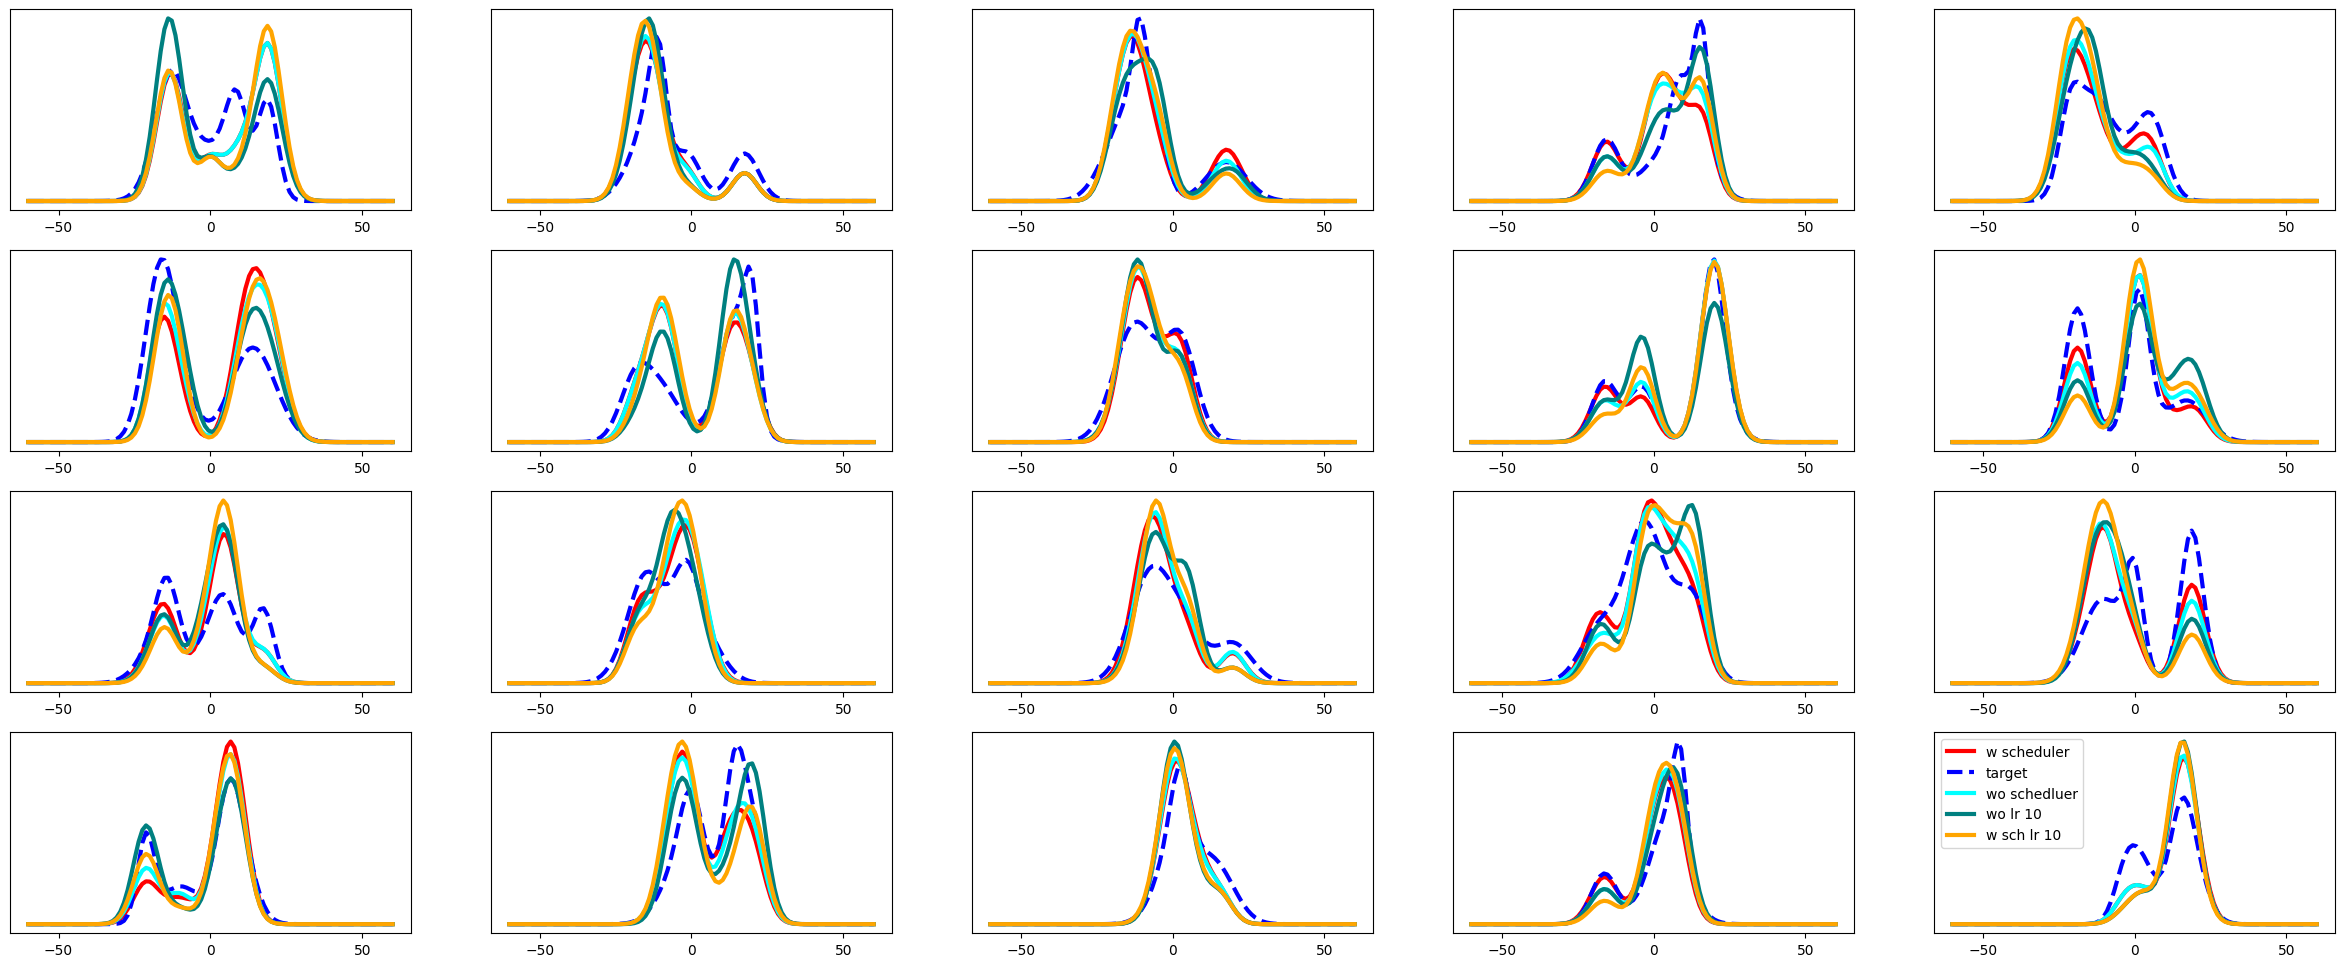

In [243]:
from scipy.stats import norm  # 1D normal for marginal
import numpy as np 
bound = 60
grid_size = 100
x_grid = np.linspace(-bound, bound, grid_size)

grid_rows = 3
grid_cols = 6
d = 20

fig, axes = plt.subplots(d//5, 5, figsize=(5 * grid_cols, 4 * grid_rows))
axes = axes.flatten()  # Flatten for easy indexing

stop = -1
mu_final = vi.vgmm.means
mu_final = vi.vgmm.optimized_means[stop]
epsilon_final = vi.vgmm.epsilons
epsilon_final = vi.vgmm.optimized_epsilons[stop]

pi_mean = target.model.means
pi_cov = target.model.covariances

for j in range(d):
    # Marginal for dimension j: Estimated distribution
    estimated_marginals = [
        norm.pdf(x_grid, loc=mu[j], scale=np.sqrt(epsilon))  # 1D Gaussian PDF
        for mu, epsilon in zip(mu_final, epsilon_final)
    ]
    # Z_estimated = np.sum(estimated_marginals, axis=0) / len(estimated_marginals)
    Z_estimated = np.sum(estimated_marginals, axis=0) / len(estimated_marginals)

    # Marginal for dimension j: Target distribution
    target_marginals = [
        norm.pdf(x_grid, loc=pim[j], scale=np.sqrt(pic[j, j]))
        for pim, pic in zip(pi_mean, pi_cov)
    ]
    Z_target = np.sum(target_marginals, axis=0) / len(target_marginals)

    axes[j].plot(x_grid, Z_estimated, label="w scheduler", color="red", linewidth=3)
    axes[j].plot(x_grid, Z_target, label="target", color="blue", linestyle="--", linewidth=3)
    # axes[j].set_title(f"dim {j}", fontweight='bold')
    axes[j].set_xticks([-50,0, 50])
    axes[j].set_yticks([])


mu_final = vi2.vgmm.means
mu_final = vi2.vgmm.optimized_means[stop]
epsilon_final = vi2.vgmm.epsilons
epsilon_final = vi2.vgmm.optimized_epsilons[stop]

pi_mean = target.model.means
pi_cov = target.model.covariances

for j in range(d):
    # Marginal for dimension j: Estimated distribution
    estimated_marginals = [
        norm.pdf(x_grid, loc=mu[j], scale=np.sqrt(epsilon))  # 1D Gaussian PDF
        for mu, epsilon in zip(mu_final, epsilon_final)
    ]
    # Z_estimated = np.sum(estimated_marginals, axis=0) / len(estimated_marginals)
    Z_estimated = np.sum(estimated_marginals, axis=0) / len(estimated_marginals)

    # Marginal for dimension j: Target distribution
    target_marginals = [
        norm.pdf(x_grid, loc=pim[j], scale=np.sqrt(pic[j, j]))
        for pim, pic in zip(pi_mean, pi_cov)
    ]
    Z_target = np.sum(target_marginals, axis=0) / len(target_marginals)

    axes[j].plot(x_grid, Z_estimated, label="wo schedluer", color="cyan", linewidth=3)
    # axes[j].plot(x_grid, Z_target, label="target", color="blue", linestyle="--", linewidth=3)
    # axes[j].set_title(f"dim {j}", fontweight='bold')
    axes[j].set_xticks([-50,0, 50])
    axes[j].set_yticks([])


mu_final = vi3.vgmm.means
mu_final = vi3.vgmm.optimized_means[stop]
epsilon_final = vi3.vgmm.epsilons
epsilon_final = vi3.vgmm.optimized_epsilons[stop]

pi_mean = target.model.means
pi_cov = target.model.covariances

for j in range(d):
    # Marginal for dimension j: Estimated distribution
    estimated_marginals = [
        norm.pdf(x_grid, loc=mu[j], scale=np.sqrt(epsilon))  # 1D Gaussian PDF
        for mu, epsilon in zip(mu_final, epsilon_final)
    ]
    # Z_estimated = np.sum(estimated_marginals, axis=0) / len(estimated_marginals)
    Z_estimated = np.sum(estimated_marginals, axis=0) / len(estimated_marginals)

    # Marginal for dimension j: Target distribution
    target_marginals = [
        norm.pdf(x_grid, loc=pim[j], scale=np.sqrt(pic[j, j]))
        for pim, pic in zip(pi_mean, pi_cov)
    ]
    Z_target = np.sum(target_marginals, axis=0) / len(target_marginals)

    axes[j].plot(x_grid, Z_estimated, label="wo lr 10", color="teal", linewidth=3)
    # axes[j].plot(x_grid, Z_target, label="target", color="blue", linestyle="--", linewidth=3)
    # axes[j].set_title(f"dim {j}", fontweight='bold')
    axes[j].set_xticks([-50,0, 50])
    axes[j].set_yticks([])



mu_final = vi4.vgmm.means
mu_final = vi4.vgmm.optimized_means[stop]
epsilon_final = vi4.vgmm.epsilons
epsilon_final = vi4.vgmm.optimized_epsilons[stop]

pi_mean = target.model.means
pi_cov = target.model.covariances

for j in range(d):
    # Marginal for dimension j: Estimated distribution
    estimated_marginals = [
        norm.pdf(x_grid, loc=mu[j], scale=np.sqrt(epsilon))  # 1D Gaussian PDF
        for mu, epsilon in zip(mu_final, epsilon_final)
    ]
    # Z_estimated = np.sum(estimated_marginals, axis=0) / len(estimated_marginals)
    Z_estimated = np.sum(estimated_marginals, axis=0) / len(estimated_marginals)

    # Marginal for dimension j: Target distribution
    target_marginals = [
        norm.pdf(x_grid, loc=pim[j], scale=np.sqrt(pic[j, j]))
        for pim, pic in zip(pi_mean, pi_cov)
    ]
    Z_target = np.sum(target_marginals, axis=0) / len(target_marginals)

    axes[j].plot(x_grid, Z_estimated, label="w sch lr 10", color="orange", linewidth=3)
    # axes[j].plot(x_grid, Z_target, label="target", color="blue", linestyle="--", linewidth=3)
    # axes[j].set_title(f"dim {j}", fontweight='bold')
    axes[j].set_xticks([-50,0, 50])
    axes[j].set_yticks([])

    
plt.legend()


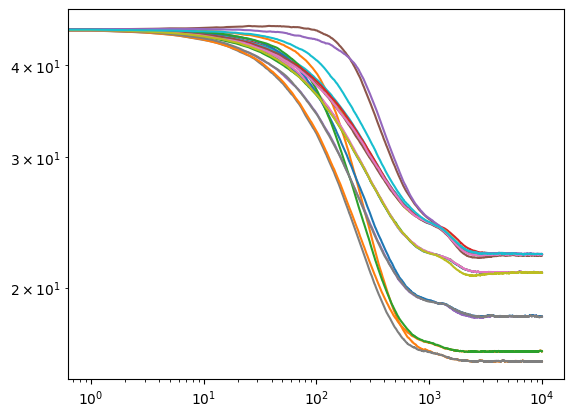

In [244]:
plt.loglog(vi.vgmm.optimized_epsilons)

(800, 20680.352027194287)

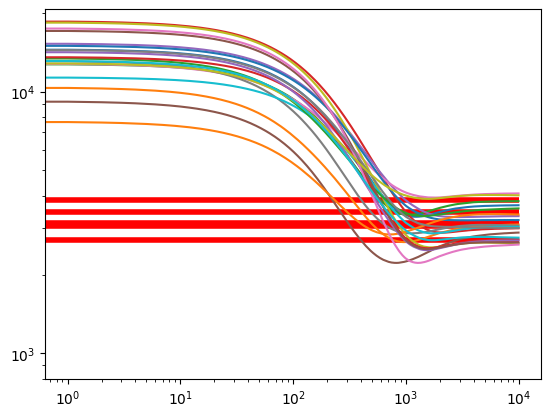

In [245]:
plt.hlines((target.model.means**2).sum(axis = -1), 0, 10000, color  = "red", lw = 4)

plt.loglog((np.array(vi.vgmm.optimized_means)**2).sum(axis = -1))
plt.ylim(800)

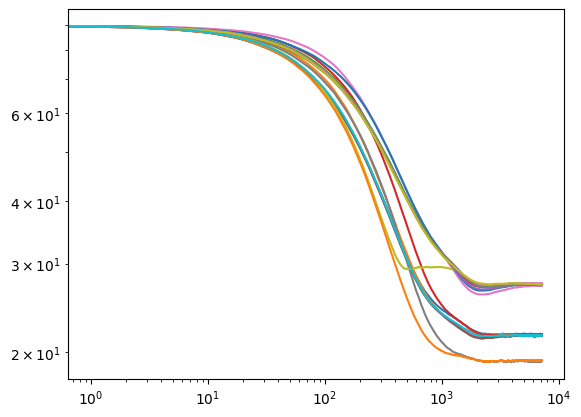

In [55]:
plt.loglog(vi.vgmm.optimized_epsilons)

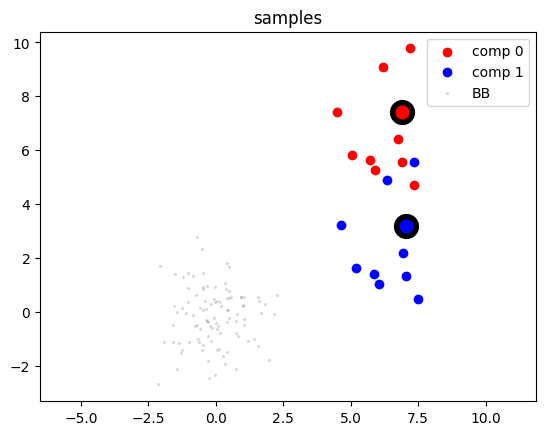

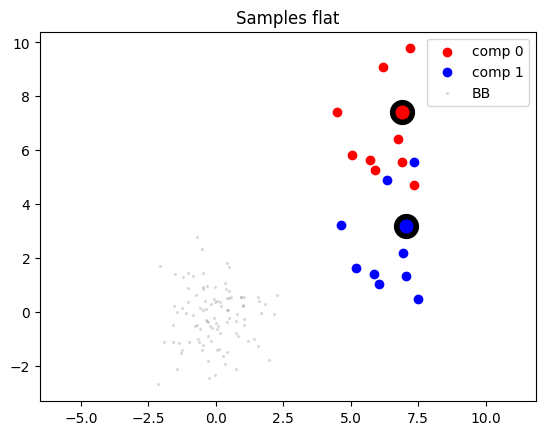

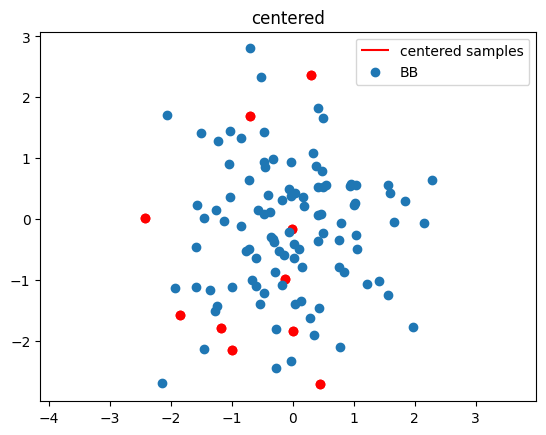

c normal que ca se superpose puisque c un bb transformé pour chaque compo


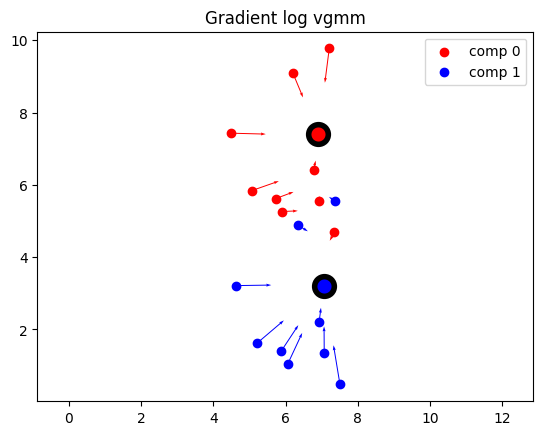

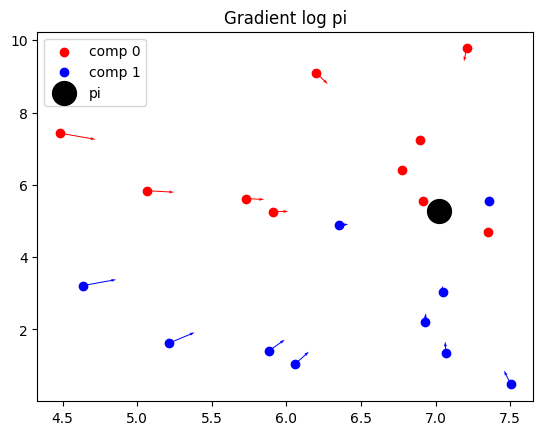

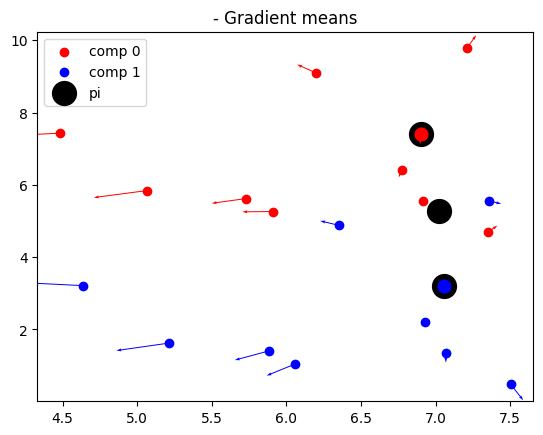

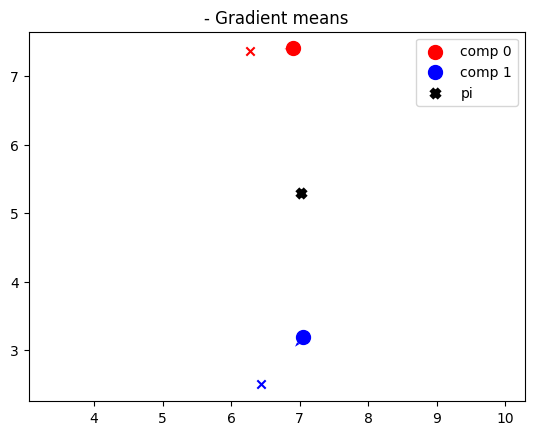

In [15]:
from einops import rearrange
samples = vi.vgmm.sample_from_each_gaussian(B = 10) # n b d 
BB = np.random.randn(100, 2)

n , b, d = samples.shape
colors  =  ["red", "blue", "green"]
for i in range(n):
    plt.scatter(samples[i,:,0], samples[i,:,1], color = colors[i], label = f"comp {i}")
    plt.scatter(vi.vgmm.means[i,0],vi.vgmm.means[i,1] ,  s=200,facecolors=colors[i], edgecolors="black", linewidths=4 )

plt.axis("equal")
plt.scatter(BB[:,0], BB[:,1], label  = "BB", color = "gray", alpha = 0.2, s = 2)

plt.legend()
plt.title("samples")
plt.show()

samples_flat = rearrange(samples, "n b d -> (n b) d")
for i in range(n):
    plt.scatter(samples_flat[i*b:(i+1)*b,0], samples_flat[i*b:(i+1)*b,1], color = colors[i], label = f"comp {i}")
    plt.scatter(vi.vgmm.means[i,0],vi.vgmm.means[i,1] ,  s=200,facecolors=colors[i], edgecolors="black", linewidths=4 )
plt.scatter(BB[:,0], BB[:,1], label  = "BB", color = "gray", alpha = 0.2, s = 2)

plt.legend()
plt.title("Samples flat")
plt.axis("equal")
plt.show()

centered_samples = samples - vi.vgmm.means[:,None] ### n,b,d

for i in range(n):
    plt.scatter(centered_samples[i,:,0], centered_samples[i,:,1], color = colors[0])
plt.vlines(0,0,0, colors = "red",  label = "centered samples")
plt.scatter(BB[:,0], BB[:,1], label  = "BB")
plt.legend()
plt.axis("equal")

plt.title("centered")
plt.show()

print("c normal que ca se superpose puisque c un bb transformé pour chaque compo")

grad_log_vgmm = vi.vgmm.gradient_log_density(samples_flat)
grad_log_pi = vi.target.model.gradient_log_density(samples_flat)

grad_log_pi = rearrange(grad_log_pi , "(n b) d -> n b d", b = b)
grad_log_vgmm = rearrange(grad_log_vgmm , "(n b) d -> n b d", b = b)
coef = 8

for i in range(n):
    plt.scatter(samples_flat[i*b:(i+1)*b,0], samples_flat[i*b:(i+1)*b,1], color = colors[i], label = f"comp {i}")
    plt.scatter(vi.vgmm.means[i,0],vi.vgmm.means[i,1] ,  s=200,facecolors=colors[i], edgecolors="black", linewidths=4 )
    plt.quiver(samples_flat[i*b:(i+1)*b,0], samples_flat[i*b:(i+1)*b,1], grad_log_vgmm[i,:, 0]*coef, grad_log_vgmm[i, :, 1]*coef, 
           angles="xy", scale_units="xy", scale=10, color=colors[i], alpha=1, width=0.002)
plt.legend()
plt.title("Gradient log vgmm")
plt.axis("equal")

plt.show()

coef = 8
for i in range(n):
    plt.scatter(samples_flat[i*b:(i+1)*b,0], samples_flat[i*b:(i+1)*b,1], color = colors[i], label = f"comp {i}")
    # plt.scatter(vi.vgmm.means[i,0],vi.vgmm.means[i,1] ,  s=200,facecolors=colors[i], edgecolors="black", linewidths=4 )
    plt.quiver(samples_flat[i*b:(i+1)*b,0], samples_flat[i*b:(i+1)*b,1], grad_log_pi[i,:, 0]*coef, grad_log_pi[i, :, 1]*coef, 
           angles="xy", scale_units="xy", scale=10, color=colors[i], alpha=1, width=0.002)

plt.scatter(vi.target.model.means[:,0],vi.target.model.means[:,1] ,  s=200,color = "black", linewidths=4 , label = "pi")
plt.legend()
plt.title("Gradient log pi")
# plt.axis("equal")

plt.show()

coef = 10
grad_means  = (grad_log_vgmm - grad_log_pi)/n
for i in range(n):
    plt.scatter(samples_flat[i*b:(i+1)*b,0], samples_flat[i*b:(i+1)*b,1], color = colors[i], label = f"comp {i}")
    plt.scatter(vi.vgmm.means[i,0],vi.vgmm.means[i,1] ,  s=200,facecolors=colors[i], edgecolors="black", linewidths=4 )
    plt.quiver(samples_flat[i*b:(i+1)*b,0], samples_flat[i*b:(i+1)*b,1],-grad_means[i,:, 0]*coef, -grad_means[i, :, 1]*coef, 
           angles="xy", scale_units="xy", scale=10, color=colors[i], alpha=1, width=0.002)

plt.scatter(vi.target.model.means[:,0],vi.target.model.means[:,1] ,  s=200,color = "black", linewidths=4 , label = "pi")
plt.legend()
plt.title("- Gradient means")
plt.show()

coef = 10
grad_means = grad_means.mean(axis = 1)

for i in range(n):
    plt.scatter(vi.vgmm.means[i,0],vi.vgmm.means[i,1] ,  color=colors[i] , label = f"comp {i}", s = 100)
    plt.quiver(vi.vgmm.means[i,0], vi.vgmm.means[i,1], - grad_means[i, 0]*coef, - grad_means[i, 1]*coef, 
           angles="xy", scale_units="xy", scale=10, color=colors[i], alpha=1, width=0.002)



lr = 5
new_means = vi.vgmm.means - lr * grad_means
for i in range(n):
    plt.scatter(new_means[i,0],new_means[i,1] ,  color=colors[i] , marker = "x")
plt.axis("equal")
    
plt.scatter(vi.target.model.means[:,0],vi.target.model.means[:,1] ,color = "black", linewidths=4 , label = "pi",  marker = "x")

plt.legend()
plt.title("- Gradient means")
plt.show()




In [10]:

vi.vgmm.update(np.array([[-1,1], [1,1]]), vi.vgmm.epsilons)

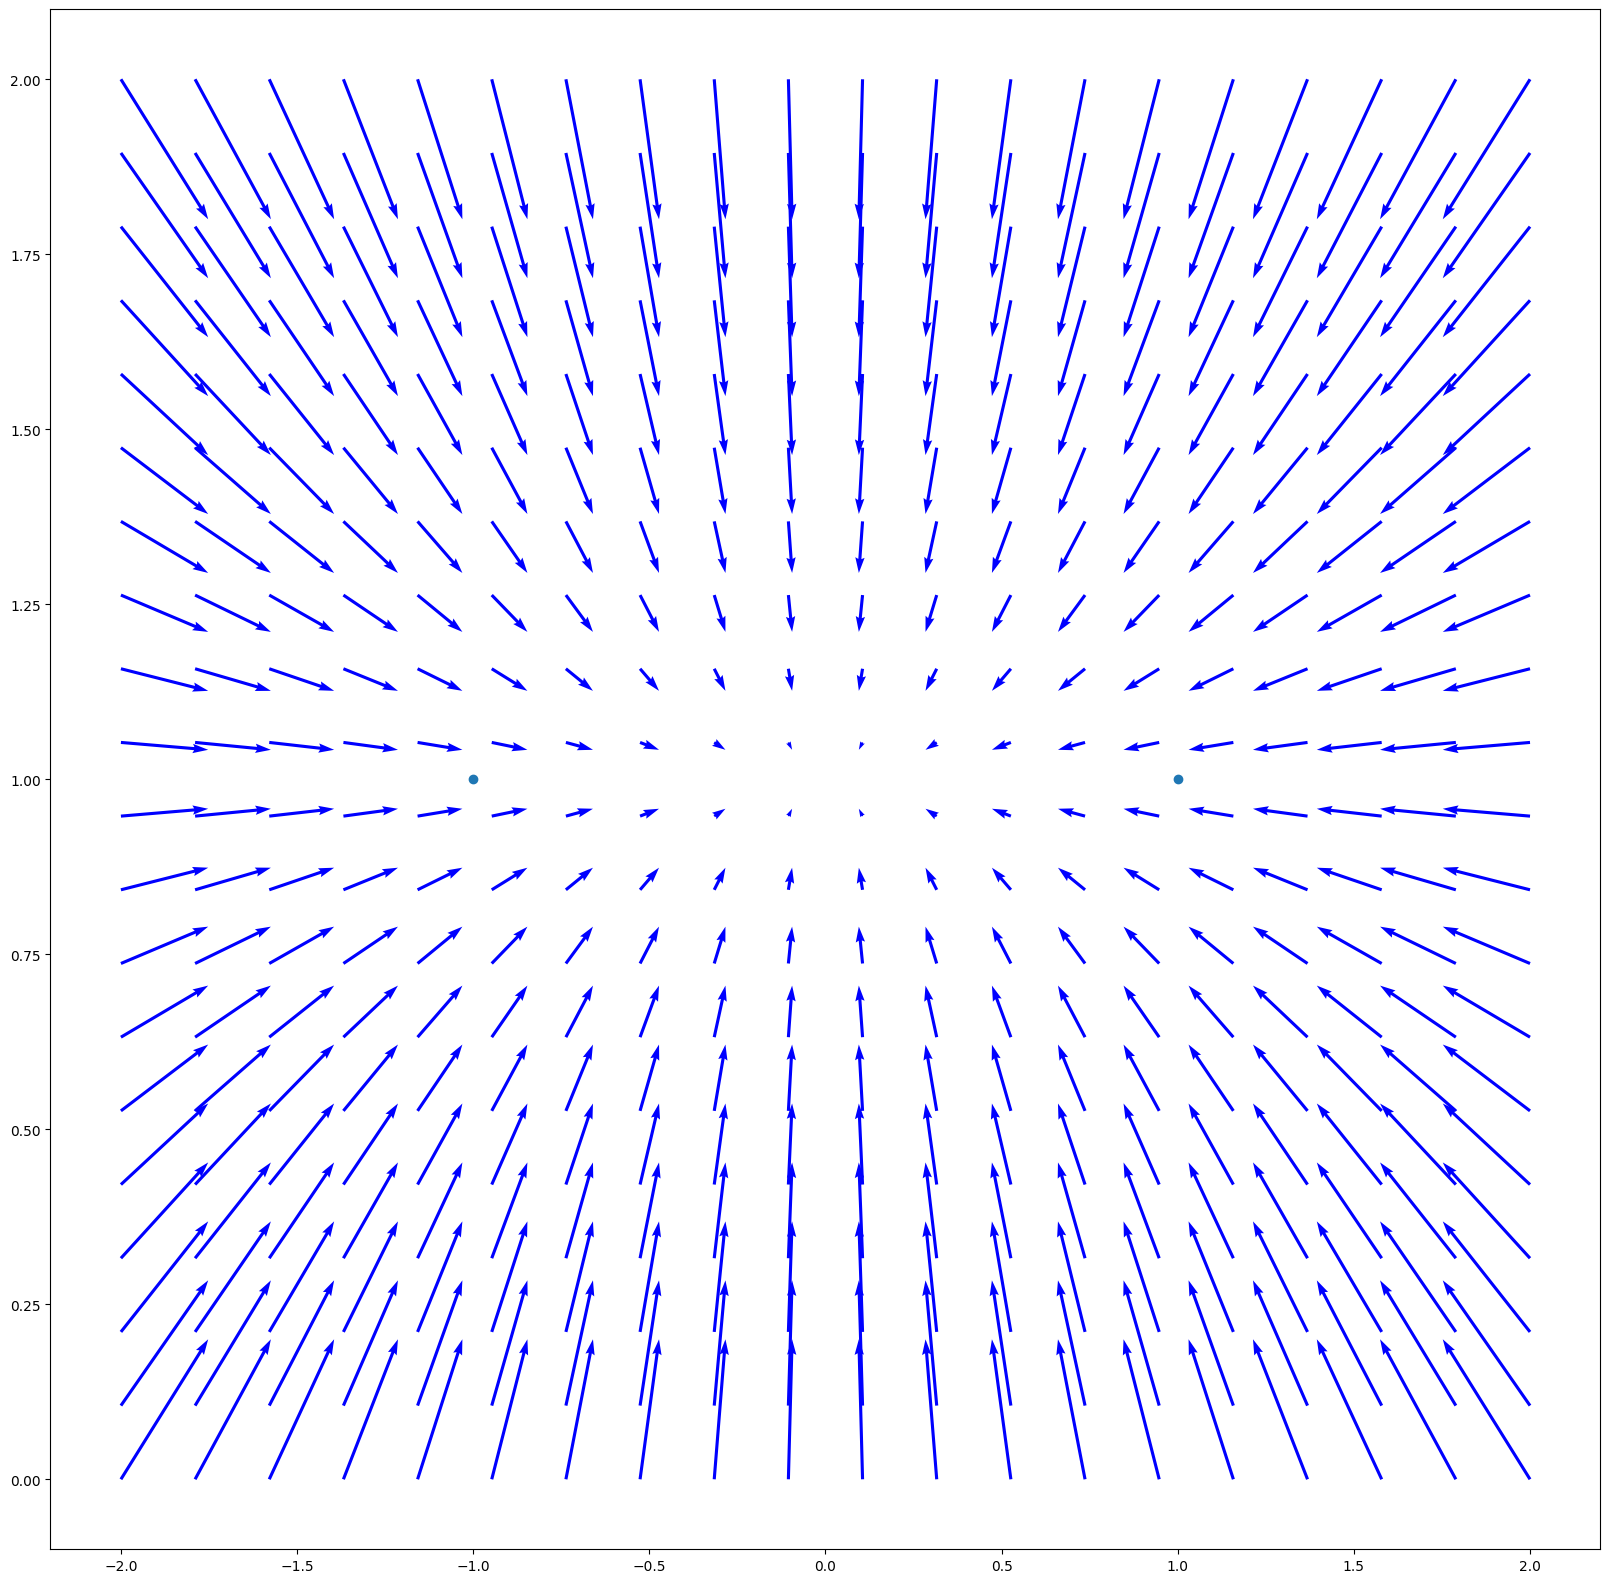

In [11]:
### iso gradient 
bound = 5
plt.figure(figsize = (20,20))
X = np.linspace(-2, 2, 20)
Y = np.linspace(0, 2, 20)
X,Y = np.meshgrid(X,Y)
pos = np.dstack((X, Y)) ## h w d
pos = rearrange(pos, "h w d -> (h w) d")
grads = vi.vgmm.gradient_log_density(pos)
# grads = rearrange(grads, "(h w) d -> h w d", h = 100)

coef = 4
plt.quiver(pos[:,0], pos[:, 1], grads[:, 0]*coef, grads[:, 1]*coef, 
        angles="xy", scale_units="xy", scale=10, color=colors[i], alpha=1, width=0.002)
plt.scatter(vi.vgmm.means[:,0], vi.vgmm.means[:,1])
